In [4]:
%%bash
# Number of total STRs analyzed
zcat /storage/mgymrek/gtex-estrs/revision/genotypes/GTExNormalizedSTRGenotypes.table.gz | \
    grep -v chrom | wc -l

175226


# Part I: Profiling expression STRs across 17 human tissues

In [1]:
# Set up
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest

############ Set up paths #############
SAVEPLOT = True
FIGPREFIX = "Figure1"

############ Tissue info ##############
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

SHORTEN = {
    "Artery-Aorta":"Artery A."     ,
    "Artery-Tibial": "Artery T.",
    "Adipose-Subcutaneous": "Adipose S.",    
    "Adipose-Visceral":"Adipose V.",
    "Brain-Caudate":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "E. Mucosa",
    "Esophagus-Muscularis":"E Muscularis",
    "Heart-LeftVentricle":"Ventricle",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed": "Skin Unexposed",
    "Skin-SunExposed":"Skin Leg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood",
    "permuted":"Permuted",
    "LCL": "LCL"
}
TISSUES = [item for item in list(COLORS.keys()) if item != "permuted"]

############ Load data ################
NGESTR = pd.read_csv(os.path.join(DATADIR, "misc", "2016_estrs_table.csv"))

# Master tables
master = {} # Map of tissue -> data
for t in TISSUES:
    d = pd.read_csv(os.path.join(DATADIR, "mastertables", "%s_master.tab"%t), sep="\t")
    d["gene"] = d["gene"].apply(lambda x: x.split(".")[0])
    d["signif_%s"%t] = d["linreg.significant"]
    master[t] =  d 
master["permuted"] = pd.read_csv(os.path.join(DATADIR, "strreg","WholeBlood_strreg_permuted.tab"), sep="\t")
master["permuted"]["linreg.pval"] = master["permuted"]["p.wald"]
master["LCL"] = NGESTR

master["LCL"]["str.id"] = master["LCL"]["str.start"].apply(lambda x: "STR_%s"%(x-1))
master["LCL"]["significant"] = master["LCL"]["signif.estr"]

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


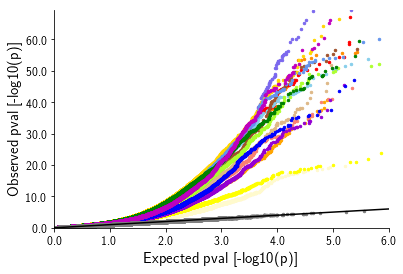

In [17]:
# Figure 1B: QQ Plot

TISSUES = sorted(TISSUES)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
maxval = 0
for t in TISSUES + ["permuted"]:
    dt = master[t][["linreg.pval"]].copy()
    dt = dt[~np.isnan(dt["linreg.pval"])]
    unif = sorted(list(np.random.uniform(low=0, high=1, size=dt.shape[0])))
    unif_log = [-1*np.log10(x) for x in unif]
    pvals = sorted(list(dt["linreg.pval"]))
    pvals_log = [-1*np.log10(x) for x in pvals]
    maxval = max([maxval]+pvals_log)
    ax.scatter(unif_log, pvals_log, color=COLORS[t], label=SHORTEN[t], s=6)
ax.plot([0,6],[0,6], color="black")
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=maxval/5*5)
ax.set_xlabel("Expected pval [-log10(p)]", size=15)
ax.set_ylabel("Observed pval [-log10(p)]", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
if SAVEPLOT:
    fig.savefig(os.path.join(RESULTSDIR, "%s_qqplot.png"%FIGPREFIX))
    fig.savefig(os.path.join(RESULTSDIR, "%s_qqplot.pdf"%FIGPREFIX))

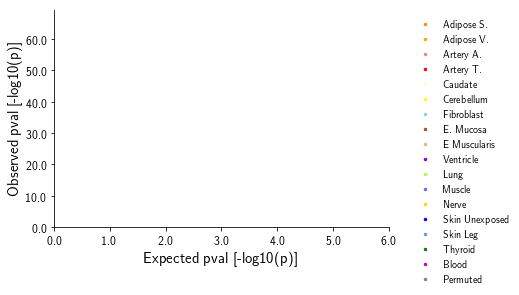

In [3]:
# Additionally plot the skeleton as pdf to use in Illustrator
fig = plt.figure()
ax = fig.add_subplot(111)
for t in TISSUES + ["permuted"]:
    ax.scatter([],[], color=COLORS[t], label=SHORTEN[t], s=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=maxval/5*5)
ax.set_xlabel("Expected pval [-log10(p)]", size=15)
ax.set_ylabel("Observed pval [-log10(p)]", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False);
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "%s_qqplot_skeleton.pdf"%FIGPREFIX))

In [7]:
#### Stats ####
numgenes = []
numtests = []
numsig = {}
num_samples = {}

# Keep track of number of unique eSTRs
starts = []
genes = []

for t in TISSUES:
    d = master[t]
    numgenes.append(len(set(d[~np.isnan(d["linreg.pval"])]["gene"])))
    numtests.append(d[~np.isnan(d["linreg.pval"])].shape[0])
    numsig[t] = sum(d["linreg.significant"])
    num_samples[t] = len(open(os.path.join(DATADIR,"samples","%s.samples"%t), "r").readlines())
    estrs = d[d["linreg.significant"]]
    starts.extend(list(estrs["str.start"]))
    genes.extend(list(estrs["gene"]))

print("Mean num genes tested per tissue: %s"%np.mean(numgenes))
print("Mean num STRxgene tests per tissue: %s"%np.mean(numtests))

# Number of unique eSTRs
allestrs = pd.DataFrame({"str.start": starts, "gene": genes}).drop_duplicates()
print("Number unique eSTRs: %s"%(allestrs[["str.start","gene"]].shape[0]))
print("Number unique genes: %s"%(len(set(allestrs["gene"]))))

print()
for t in numsig:
    print("%s: %s %s"%(t, num_samples[t], numsig[t]))

Mean num genes tested per tissue: 15840.29411764706
Mean num STRxgene tests per tissue: 262593.23529411765
Number unique eSTRs: 28375
Number unique genes: 12494

Lung: 259 3554
Artery-Aorta: 191 2809
WholeBlood: 336 3117
Heart-LeftVentricle: 199 2147
Nerve-Tibial: 265 4961
Skin-SunExposed: 297 4316
Esophagus-Mucosa: 255 3600
Muscle-Skeletal: 343 3596
Brain-Cerebellum: 107 1947
Adipose-Visceral: 193 2089
Artery-Tibial: 276 3956
Cells-Transformedfibroblasts: 225 3737
Adipose-Subcutaneous: 270 3777
Skin-NotSunExposed: 209 2745
Esophagus-Muscularis: 214 3157
Brain-Caudate: 108 1003
Thyroid: 262 4500


(0.7456563679219415, 0.0005900003939143951)

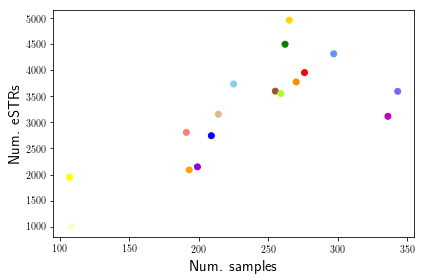

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter([num_samples[t] for t in TISSUES], [numsig[t] for t in TISSUES], color=[COLORS[t] for t in TISSUES])
ax.set_xlabel("Num. samples", size=15)
ax.set_ylabel("Num. eSTRs", size=15);

fig.tight_layout()
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_SamplePower.pdf"));

scipy.stats.pearsonr([num_samples[t] for t in TISSUES], [numsig[t] for t in TISSUES])

In [5]:
# How do effect sizes compare to those from LCLs?
lcl = master["LCL"]
lclcorr = {}
for t in TISSUES:
    d = master[t]
    d = d[~np.isnan(d["linreg.pval"])].copy()
    d["str.start"] = d["str.start"]+1
    dm = pd.merge(d, lcl, on=["gene","str.start"])
    dm = dm[dm["linreg.significant"] | dm["significant"]]
    lclcorr[t] = scipy.stats.pearsonr(dm["linreg.beta"], dm["beta"])[0]
print("Mean corr with LCL: %s"%(np.mean(list(lclcorr.values()))))
lclcorr

Mean corr with LCL: 0.4488860897836594


{'Adipose-Subcutaneous': 0.46901960334056164,
 'Adipose-Visceral': 0.4917676657492324,
 'Artery-Aorta': 0.45613939993551417,
 'Artery-Tibial': 0.44215527116884124,
 'Brain-Caudate': 0.396185377911028,
 'Brain-Cerebellum': 0.30439529817036776,
 'Cells-Transformedfibroblasts': 0.5113812161250413,
 'Esophagus-Mucosa': 0.4944410672400956,
 'Esophagus-Muscularis': 0.46907505366514457,
 'Heart-LeftVentricle': 0.447527794063479,
 'Lung': 0.49840521572187113,
 'Muscle-Skeletal': 0.43060321179332245,
 'Nerve-Tibial': 0.41693559228896643,
 'Skin-NotSunExposed': 0.460451221658746,
 'Skin-SunExposed': 0.4391750731239245,
 'Thyroid': 0.41917936583298926,
 'WholeBlood': 0.4842260985330843}

In [111]:
# For each tissue:
#  - how many pass ANOVA at q<0.1?
#  - how many eSTR have highest caviar score?

MINANOVAQ = 0.1 # 10% FDR for ANOVA analysis
MINANOVAP = 0.05 # nominal p-value for ANOVA analysis
MIN_CAUSAL_SCORE = 0.3 # top 5% of all

perc_caviar = []
perc_anova_nom = []
perc_anova_fdr = []

caviar_anova_qval = []
caviar_anova_nom = []

for t in TISSUES:
    d = master[t]
    tissue_estrs = d[(d["linreg.significant"])].copy()
    num_estrs = tissue_estrs.shape[0]
    num_best_caviar = tissue_estrs[tissue_estrs["caviar.str.rank"]==1].shape[0]
    num_anova_nom = tissue_estrs[(tissue_estrs["anova.pval"]<MINANOVAP) | np.isnan(tissue_estrs["anova.pval"])].shape[0]
    anova_p = list(tissue_estrs["anova.pval"])
    anova_p = [item for item in anova_p if not np.isnan(item)]
    rejected, anova_q = statsmodels.stats.multitest.fdrcorrection(list(anova_p))
    tissue_estrs["anova.qval"] = np.nan
    tissue_estrs.loc[~np.isnan(tissue_estrs["anova.pval"]),"anova.qval"] = anova_q
    num_anova_fdr = len([item for item in anova_q if item < MINANOVAQ])
    num_perfectLD = sum(np.isnan(tissue_estrs["anova.pval"]))
    print("%s numestrs=%s perccaviar=%.2f perc_anova_nom=%.2f perc_anova_q=%s perfectLD=%s"%(t, num_estrs, \
                                                                            num_best_caviar*1.0/num_estrs, \
                                                                            num_anova_nom*1.0/num_estrs, \
                                                                           num_anova_fdr*1.0/num_estrs, \
                                                                                            num_perfectLD))
    perc_caviar.append(num_best_caviar*1.0/num_estrs)
    perc_anova_nom.append(num_anova_nom*1.0/num_estrs)
    perc_anova_fdr.append(num_anova_fdr*1.0/num_estrs)

    caviar_pass = tissue_estrs["caviar.str.score"]>=MIN_CAUSAL_SCORE
    num_caviar_top = (tissue_estrs[caviar_pass].shape[0])
    num_anova_total_fdr = (tissue_estrs[caviar_pass & (tissue_estrs["anova.qval"]<=MINANOVAQ)].shape[0])
    num_anova_total_nom = (tissue_estrs[caviar_pass & (tissue_estrs["anova.pval"]<=MINANOVAP)].shape[0])
    caviar_anova_qval.append(num_anova_total_fdr*1.0/num_caviar_top)
    caviar_anova_nom.append(num_anova_total_nom*1.0/num_caviar_top)
    
print("\n")
print("Average percent best CAVIAR: %s"%np.mean(perc_caviar))
print("Average percent pass ANOVA p<%s: %s"%(MINANOVAP, np.mean(perc_anova_nom)))
print("Average percent pass ANOVA q<%s: %s"%(MINANOVAQ, np.mean(perc_anova_fdr)))

print("Of top CAVIAR, how many pass ANOVA FDR %s"%(np.mean(caviar_anova_qval)))
print("Of top CAVIAR, how many pass ANOVA nom pval %s"%(np.mean(caviar_anova_nom)))

Adipose-Subcutaneous numestrs=3777 perccaviar=0.12 perc_anova_nom=0.27 perc_anova_q=0.1832141911570029 perfectLD=0
Adipose-Visceral numestrs=2089 perccaviar=0.12 perc_anova_nom=0.24 perc_anova_q=0.16371469602680708 perfectLD=0
Artery-Aorta numestrs=2809 perccaviar=0.12 perc_anova_nom=0.26 perc_anova_q=0.1772872908508366 perfectLD=1
Artery-Tibial numestrs=3956 perccaviar=0.11 perc_anova_nom=0.27 perc_anova_q=0.18832153690596562 perfectLD=0
Brain-Caudate numestrs=1003 perccaviar=0.17 perc_anova_nom=0.25 perc_anova_q=0.16350947158524426 perfectLD=0
Brain-Cerebellum numestrs=1947 perccaviar=0.15 perc_anova_nom=0.24 perc_anova_q=0.1510015408320493 perfectLD=0
Cells-Transformedfibroblasts numestrs=3737 perccaviar=0.12 perc_anova_nom=0.27 perc_anova_q=0.17473909553117473 perfectLD=0
Esophagus-Mucosa numestrs=3600 perccaviar=0.12 perc_anova_nom=0.26 perc_anova_q=0.1825 perfectLD=0
Esophagus-Muscularis numestrs=3157 perccaviar=0.12 perc_anova_nom=0.26 perc_anova_q=0.17136522014570796 perfectLD=

In [112]:
# Build table with caviar scores

chroms = []
starts = []
tissues = []
genes = []
genenames = []
scores = []
betas = []
pvals = []

for t in TISSUES:
    d = master[t]
    tissue_estrs = d[d["linreg.significant"]].copy()
    chroms.extend(list(tissue_estrs["chrom"]))
    starts.extend(list(tissue_estrs["str.start"]))
    tissues.extend([t]*tissue_estrs.shape[0])
    genes.extend(list(tissue_estrs["gene"]))
    genenames.extend(list(tissue_estrs["gene.name"]))
    scores.extend(list(tissue_estrs["caviar.str.score"]))
    betas.extend(list(tissue_estrs["linreg.beta"]))
    pvals.extend(list(tissue_estrs["linreg.pval"]))
    print("%s: %s"%(t, tissue_estrs[(tissue_estrs["caviar.str.score"]>=MIN_CAUSAL_SCORE) | np.isnan(tissue_estrs["caviar.str.score"])].shape[0]))
    
all_causal = pd.DataFrame({
    "chrom": chroms,
    "str.start": starts,
    "gene": genes,
    "gene.name": genenames,
    "score": scores,
    "beta": betas,
    "tissue": tissues,
    "pval": pvals,
})

def maxabs(x):
    abs_x = [abs(item) for item in x]
    return list(x)[abs_x.index(max(abs_x))]

def maxnan(x):
    xnan = [item for item in x if not np.isnan(item)]
    if len(xnan)==0: return np.nan
    else: return max(xnan)

def concat(x):
    return ";".join([str(item) for item in x])

all_causal["tissue_info"] = all_causal.apply(lambda x: "%s_%.2f_%.2f"%(x["tissue"], x["beta"], x["score"]), 1)
all_causal["num.e"] = 1
aggdir = {"tissue_info": concat,"score": maxnan,"beta": maxabs,"pval": min, "num.e": sum}
all_unique_causal = all_causal.groupby(["chrom","str.start","gene","gene.name"], as_index=False).agg(aggdir)

# Add info for table
d = pd.read_csv(os.path.join(DATADIR,"mastertables","WholeBlood_master.tab"), sep="\t")
d["gene"] = d["gene"].apply(lambda x: x.split(".")[0])
causaltable = pd.merge(all_unique_causal, d[["gene","str.start","str.end","str.motif.forward","str.motif.reverse"]], on=["gene","str.start"])
#causaltable.ix[np.isnan(causaltable["score"]),"score"] = 1 # if no scores, it's because there were no SNPs. TODO maybe we should do something different?
causaltable.to_csv(os.path.join(RESULTSDIR, "SuppTable_CAVIAR.tsv"), sep="\t", index=False)

Adipose-Subcutaneous: 145
Adipose-Visceral: 74
Artery-Aorta: 111
Artery-Tibial: 131
Brain-Caudate: 52
Brain-Cerebellum: 83
Cells-Transformedfibroblasts: 112
Esophagus-Mucosa: 122
Esophagus-Muscularis: 124
Heart-LeftVentricle: 100
Lung: 118
Muscle-Skeletal: 122
Nerve-Tibial: 169
Skin-NotSunExposed: 81
Skin-SunExposed: 139
Thyroid: 130
WholeBlood: 108


/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [114]:
# Get score threshold for top 5%
np.percentile(causaltable[~np.isnan(causaltable["score"])]["score"], [95])

array([0.30075175])

In [115]:
# How many overall
num_estrs = causaltable[["chrom","str.start","gene"]].drop_duplicates().shape[0]
num_causal = causaltable[causaltable["score"]>=MIN_CAUSAL_SCORE][["chrom","str.start","gene"]].drop_duplicates().shape[0]
print("Total: %s, (%s)"%(causaltable[causaltable["score"]>=MIN_CAUSAL_SCORE].shape[0], num_causal*1.0/num_estrs))
print("Total genes: %s"%(len(set(causaltable[causaltable["score"]>=MIN_CAUSAL_SCORE]["gene"]))))


Total: 1420, (0.05004405286343613)
Total genes: 1323


Adipose-Subcutaneous: meandiff=0.38, mediandiff=0.36
Adipose-Visceral: meandiff=0.48, mediandiff=0.45
Artery-Aorta: meandiff=0.40, mediandiff=0.36
Artery-Tibial: meandiff=0.46, mediandiff=0.43
Brain-Caudate: meandiff=0.41, mediandiff=0.38
Brain-Cerebellum: meandiff=0.43, mediandiff=0.36
Cells-Transformedfibroblasts: meandiff=0.41, mediandiff=0.39
Esophagus-Mucosa: meandiff=0.37, mediandiff=0.33
Esophagus-Muscularis: meandiff=0.41, mediandiff=0.37
Heart-LeftVentricle: meandiff=0.39, mediandiff=0.39
Lung: meandiff=0.40, mediandiff=0.36
Muscle-Skeletal: meandiff=0.42, mediandiff=0.42
Nerve-Tibial: meandiff=0.42, mediandiff=0.36
Skin-NotSunExposed: meandiff=0.42, mediandiff=0.38
Skin-SunExposed: meandiff=0.39, mediandiff=0.35
Thyroid: meandiff=0.46, mediandiff=0.43
WholeBlood: meandiff=0.37, mediandiff=0.34
Correlation of str vs. snp scores: (-0.022224626084962455, 0.33446237919891453)
Average overall difference: 0.41095766688559315


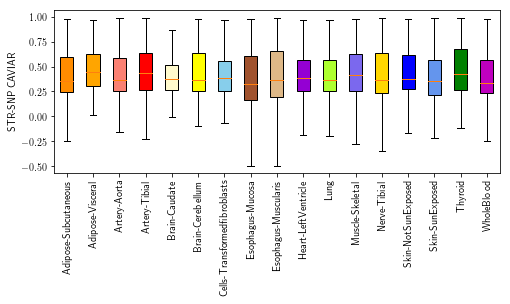

In [116]:
# Difference in top STR vs. top SNP score for causal things
diffs = []
str_scores = []
snp_scores = []
TISSUES.sort()
for t in TISSUES:
    d = master[t]
    causal = d["caviar.str.score"]>=MIN_CAUSAL_SCORE
    diffs.append(list(d[causal]["caviar.str.score"]-d[causal]["caviar.topsnp.score"]))
    print("%s: meandiff=%.2f, mediandiff=%.2f"%(t, np.mean(diffs[-1]), np.median(diffs[-1])))
    str_scores.extend(list(d[causal]["caviar.str.score"]))
    snp_scores.extend(list(d[causal]["caviar.topsnp.score"]))

print("Correlation of str vs. snp scores: %s"%str(scipy.stats.pearsonr(str_scores, snp_scores)))
print("Average overall difference: %s"%(np.mean([str_scores[i]-snp_scores[i] for i in range(len(str_scores))])))
fig = plt.figure()
fig.set_size_inches((8, 3))
ax = fig.add_subplot(111)
bp = ax.boxplot(diffs, patch_artist=True, sym="")
colors = [COLORS[t] for t in TISSUES]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xticklabels(TISSUES, rotation=90);
ax.set_ylabel("STR-SNP CAVIAR");
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_CAVIAR_DiffSNPvSTR.pdf"))

In [98]:
# Literature examples
names = ["CSTB","NOP56","MMP9","EGFR","TP53I3","ALOX5","IFNG", "UGT1A1"]
chroms = ["chr21","chr20","chr20","chr7","chr2","chr10","chr12","chr2"]
poss = [45196326,2633379,44637412,55088253,24307211,45869548,68552495,234668880]

for i in range(len(names)):
    print("\n***"+names[i]+"***")
    for t in TISSUES:
        d = master[t]
        x = (d[(d["chrom"]==chroms[i]) & (d["str.start"]==poss[i]) & (d["gene.name"]==names[i])])
        if x.shape[0] == 0: continue
        pval = x["linreg.pval"].values[0]
        beta = x["linreg.beta"].values[0]
        cav = x["caviar.str.score"].values[0]
        if pval<0.01: mark = ""
        else: mark = "NO: "
        print("%s%s; p=%.2g; B=%.2f; CAVIAR=%s"%(mark, t, pval, beta, cav))


***CSTB***
Adipose-Subcutaneous; p=0.00015; B=0.23; CAVIAR=0.0158083
Adipose-Visceral; p=9.7e-08; B=0.38; CAVIAR=0.732784
Artery-Aorta; p=2.9e-10; B=0.44; CAVIAR=0.979914
Artery-Tibial; p=3e-21; B=0.53; CAVIAR=1.0
Brain-Caudate; p=0.0006; B=0.33; CAVIAR=0.011832700000000002
NO: Brain-Cerebellum; p=0.045; B=0.20; CAVIAR=nan
Cells-Transformedfibroblasts; p=5.8e-26; B=0.64; CAVIAR=1.0
NO: Esophagus-Mucosa; p=0.14; B=0.10; CAVIAR=nan
Esophagus-Muscularis; p=8.1e-10; B=0.41; CAVIAR=0.988081
Heart-LeftVentricle; p=1.8e-11; B=0.46; CAVIAR=0.9609219999999999
Lung; p=0.0046; B=0.18; CAVIAR=0.00874627
Muscle-Skeletal; p=1e-26; B=0.54; CAVIAR=1.0
Nerve-Tibial; p=6.9e-16; B=0.48; CAVIAR=0.998872
Skin-NotSunExposed; p=2.9e-06; B=0.32; CAVIAR=0.0132458
Skin-SunExposed; p=2.7e-19; B=0.49; CAVIAR=0.999706
Thyroid; p=3e-17; B=0.50; CAVIAR=0.999799
WholeBlood; p=2.9e-15; B=0.42; CAVIAR=0.985656

***NOP56***
Adipose-Subcutaneous; p=0.00031; B=0.22; CAVIAR=0.22858
NO: Adipose-Visceral; p=0.21; B=0.09; CA

In [16]:
# Pi1 heatmap for tissue sharing
ntissues = len(TISSUES)
corrMatrix = np.full((ntissues, ntissues), np.nan)
for repl in TISSUES:
    treps = []
    for disc in TISSUES:
        d = master[disc]
        r = master[repl]
        r = r[~np.isnan(r["linreg.pval"])]
        dset = d[d["linreg.significant"]][["chrom","str.start","gene"]]
        rset = pd.merge(dset, r[["chrom","str.start","gene","linreg.pval"]], on=["chrom","str.start","gene"])
        num_repl = rset[rset["linreg.pval"]<=0.05].shape[0]
        d_ind = TISSUES.index(disc)
        r_ind = TISSUES.index(repl)
        corrMatrix[d_ind, r_ind] = num_repl*1.0/rset.shape[0]
        treps.append(num_repl*1.0/rset.shape[0])
    print("Repl %s: %s"%(repl, np.mean(treps)))

Repl WholeBlood: 0.4923257585267666
Repl Artery-Tibial: 0.641372309629425
Repl Lung: 0.6150678495280615
Repl Heart-LeftVentricle: 0.510014627956321
Repl Esophagus-Mucosa: 0.5770547885803634
Repl Skin-NotSunExposed: 0.5570878257482788
Repl Brain-Cerebellum: 0.44017533388894753
Repl Brain-Caudate: 0.3889121624106563
Repl Thyroid: 0.6331823666314127
Repl Artery-Aorta: 0.5884662738090515
Repl Cells-Transformedfibroblasts: 0.5721103301891018
Repl Esophagus-Muscularis: 0.6044779743871864
Repl Muscle-Skeletal: 0.5671589676657273
Repl Nerve-Tibial: 0.6728740721258466
Repl Adipose-Visceral: 0.5445383134343035
Repl Adipose-Subcutaneous: 0.6452992674665322
Repl Skin-SunExposed: 0.6358618211685548


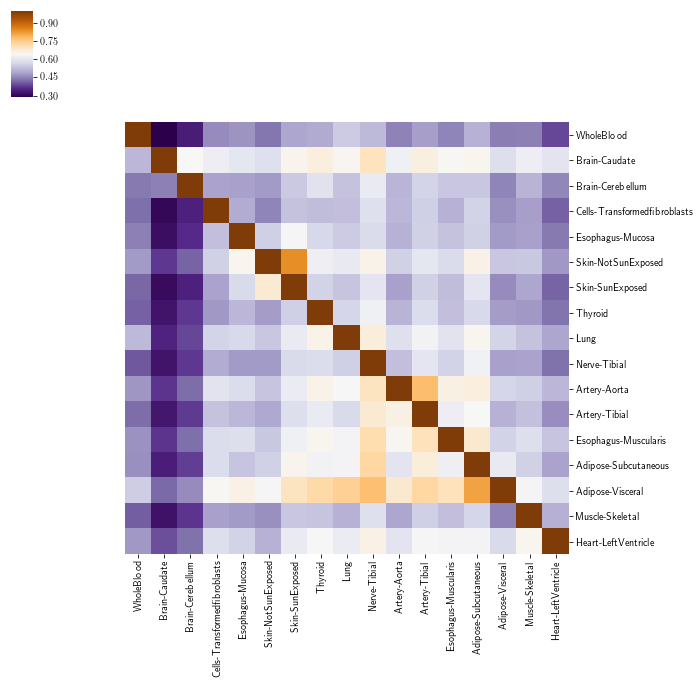

In [14]:
corrMatrix = pd.DataFrame(corrMatrix, columns=TISSUES, index=TISSUES)

torder = ["WholeBlood","Brain-Caudate","Brain-Cerebellum","Cells-Transformedfibroblasts",
         "Esophagus-Mucosa","Skin-NotSunExposed","Skin-SunExposed","Thyroid","Lung",
         "Nerve-Tibial","Artery-Aorta","Artery-Tibial","Esophagus-Muscularis","Adipose-Subcutaneous",
         "Adipose-Visceral","Muscle-Skeletal","Heart-LeftVentricle"]

# Row=discovery, col=replication
cg = sns.clustermap(corrMatrix.loc[torder,torder], cmap="PuOr_r", row_cluster=False, col_cluster=False)
#cg.ax_col_dendrogram.set_visible(False)
if SAVEPLOT: cg.savefig(os.path.join(RESULTSDIR, "SuppFig_Pi1Sharing.pdf"))